# Cryptocurrency Price Forecasting

Cryptocurrencies are fast becoming rivals to traditional currency across the world. The digital currencies are available to purchase in many different places, making it accessible to everyone, and with retailers accepting various cryptocurrencies it could be a sign that money as we know it is about to go through a major change.

In addition, the blockchain technology on which many cryptocurrencies are based, with its revolutionary distributed digital backbone, has many other promising applications. Implementations of secure, decentralized systems can aid us in conquering organizational issues of trust and security that have plagued our society throughout the ages. In effect, we can fundamentally disrupt industries core to economies, businesses and social structures, eliminating inefficiency and human error.

In this notebook I attempt to predict the price of cryptocurrencies for the next few months.

I will initially work with only the Bitcoin data and may in future generalise the code and use it for other cryptos if it works out for  Bitcoin.


Prequels to this notebook can be found here:
 - https://www.kaggle.com/taniaj/cryptocurrency-predictions-with-arima
 - https://www.kaggle.com/taniaj/cryptocurrency-market-analysis

## Contents:
   * [Stationarity check and Seasonal decomposition](#stationarity_check)
   * [Transformation](#transformation)
   * [Differencing](#differencing)
       * [Seasonal differentiation](#seasonal_differentiation)
       * [Regular differentiation](#regular_differentiation)
   * [Autocorrelation](#autocorrelation)
   * [Monthly Forecasting](#monthly_forecasting)
       * [ARIMAModel](#arima_model)
           * [Analysis of Results](#analysis_arima)
           * [PredictionARIMA](#prediction_arima)
       * [SARIMAModel](#sarimax_model)
           * [Analysis of Results](#analysis_sarimax)
           * [Prediction](#prediction_sarimax)
       * [Validation](#validation)
           * [Baseline](#baseline)
           * [SARIMAX](#validation_sarimax)

In [35]:
!pip install seaborn
!pip install datetime
!pip install pandas
!pip install statsmodels

import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import statsmodels.api as sm
from itertools import product
from math import sqrt
from sklearn.metrics import mean_squared_error 
from sklearnex import patch_sklearn
patch_sklearn()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 })

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


ModuleNotFoundError: No module named 'sklearnex'

In [4]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('all_currencies.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [5]:
df.sample(5)

,Symbol,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,
2016-11-23,ARC,0.001084,0.001346,0.001075,0.001093,5.0,23179.0
2018-07-11,ZENI,0.000382,0.000386,0.000380,0.000383,23.0,382463.0
2017-04-27,PXC,0.000501,0.000661,0.000501,0.000645,133.0,NaN
2016-12-16,HUSH,0.009348,0.019832,0.009348,0.013343,23.0,NaN
2017-08-09,BRK,0.102152,0.145262,0.094734,0.112272,157241.0,1848949.0


In [6]:
# Extract the bitcoin data only
btc=df[df['Symbol']=='BTC']
# Drop some columns
btc.drop(['Volume', 'Market Cap'],axis=1,inplace=True) 

In [7]:
# Lets take just the last year 
#btc = btc.loc['2017']
#btc.shape

## Stationarity check and Seasonal decomposition <a class="anchor" id="stationary_check"></a>

If a timeseries is stationary, it implies the lack of broad trends (changes in mean and variance over time) in the data. This is important as a consideration in time series forecasting.

The statsmodels library provides a seasonal_decompose method, an implementation of the naive decomposition method, which we will use to examine our timeseries.

In [8]:
# Resampling to monthly frequency
btc_month = btc.resample('M').mean()

Dickey–Fuller test: p=0.695832


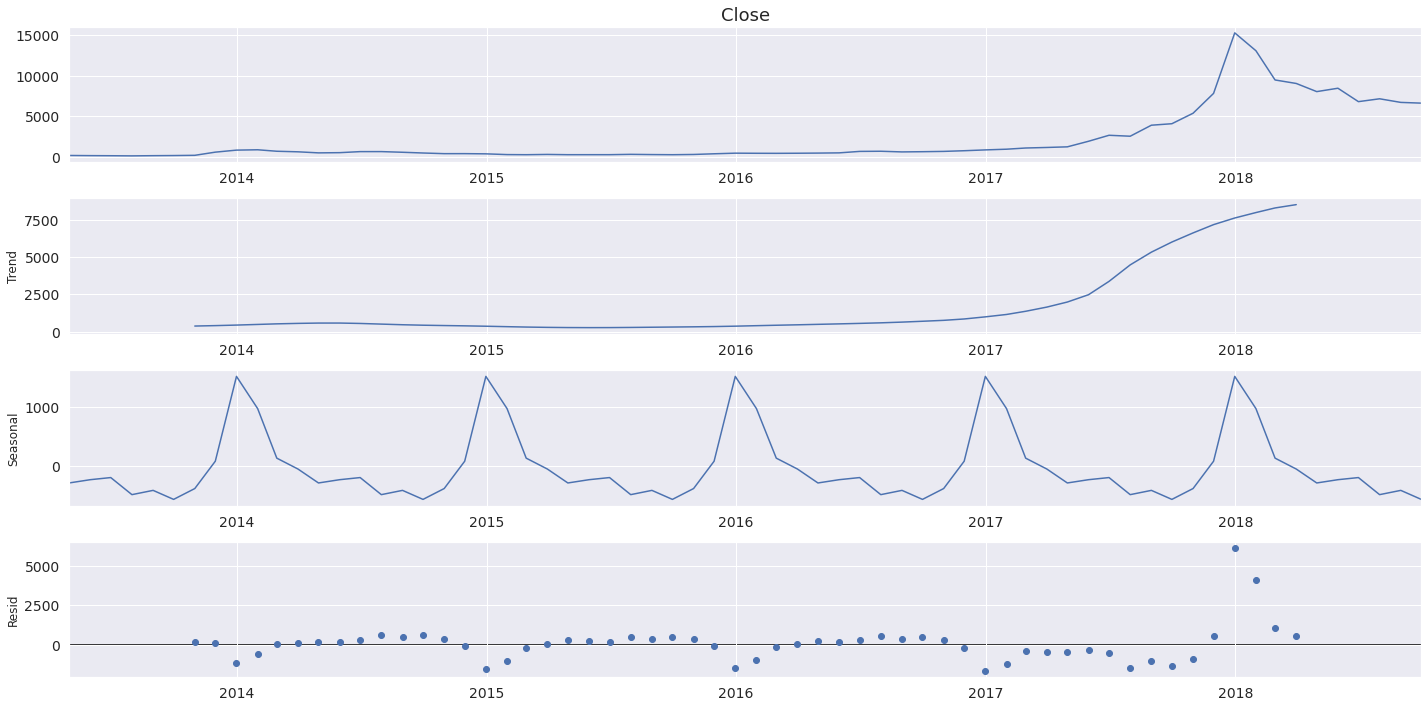

In [9]:
#seasonal_decompose(btc_month.close, freq=12).plot()
seasonal_decompose(btc_month.Close, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.Close)[1])

The p-value indicates that series is not stationary with 99.88% confidence.

Most interesting is the seasonal component which was extracted, which looks like it repeats itself on a yearly basis.

We can also see that the residuals are fairly constant until around the start of 2017, which is going to make forecasting difficult as we are still inside of this time period where the price is moving insanely.

However, lets proceed anyway. 

## Box-Cox Transformation </a><a class="anchor" id="transformation"></a>

Lets use the Box-Cox transformation to suppress some of the variance.

The Box-Cox transformation is a family of power transformations indexed by a parameter lambda. Whenever you use it the parameter needs to be estimated from the data. In time series the process could have a non-constant variance. if the variance changes with time the process is nonstationary. It is often desirable to transform a time series to make it stationary. Sometimes after applying Box-Cox with a particular value of lambda the process may look stationary. It is sometimes possible that even if after applying the Box-Cox transformation the series does not appear to be stationary, diagnostics from ARIMA modeling can then be used to decide if differencing or seasonal differencing might be useful to to remove polynomial trends or seasonal trends respectively. After that the result might be an ARMA model that is stationary. If diagnostics confirm the orders p an q for the ARMA model, the AR and MA parameters can then be estimated.

In [10]:
# Box-Cox Transformations
btc_month['close_box'], lmbda = stats.boxcox(btc_month.Close)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])

Dickey–Fuller test: p=0.510680


The p-value indicates that series is still not stationary.

## Differencing <a class="anchor" id="differencing"></a>

When building models to forecast time series data (like ARIMA), another pre-processing step is differencing the data (calculating sequentially xt−xt−1) until we get to a point where the series is stationary. Models account for oscillations but not for trends, and therefore, accounting for trends by differencing allows us to use the models that account for oscillations.

Once the model has been constructed, we can account for trends separately, by adding the trends component-wise.

### Seasonal differentiation  <a class="anchor" id="seasonal_differentiationn"></a>

One method of differencing data is seasonal differencing, which involves computing the difference between an observation and the corresponding observation in the previous year.

In [11]:
# Seasonal differentiation (12 months)
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.059548


The p-value indicates that series is still not stationary.

In [12]:
# Seasonal differentiation (3 months)
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.010404


The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05.

### Regular differentiation  <a class="anchor" id="regular_differentiation"></a>

Sometimes it may be necessary to difference the data a second time to obtain a stationary time series, which is referred to as second order differencing.

Dickey–Fuller test: p=0.015929


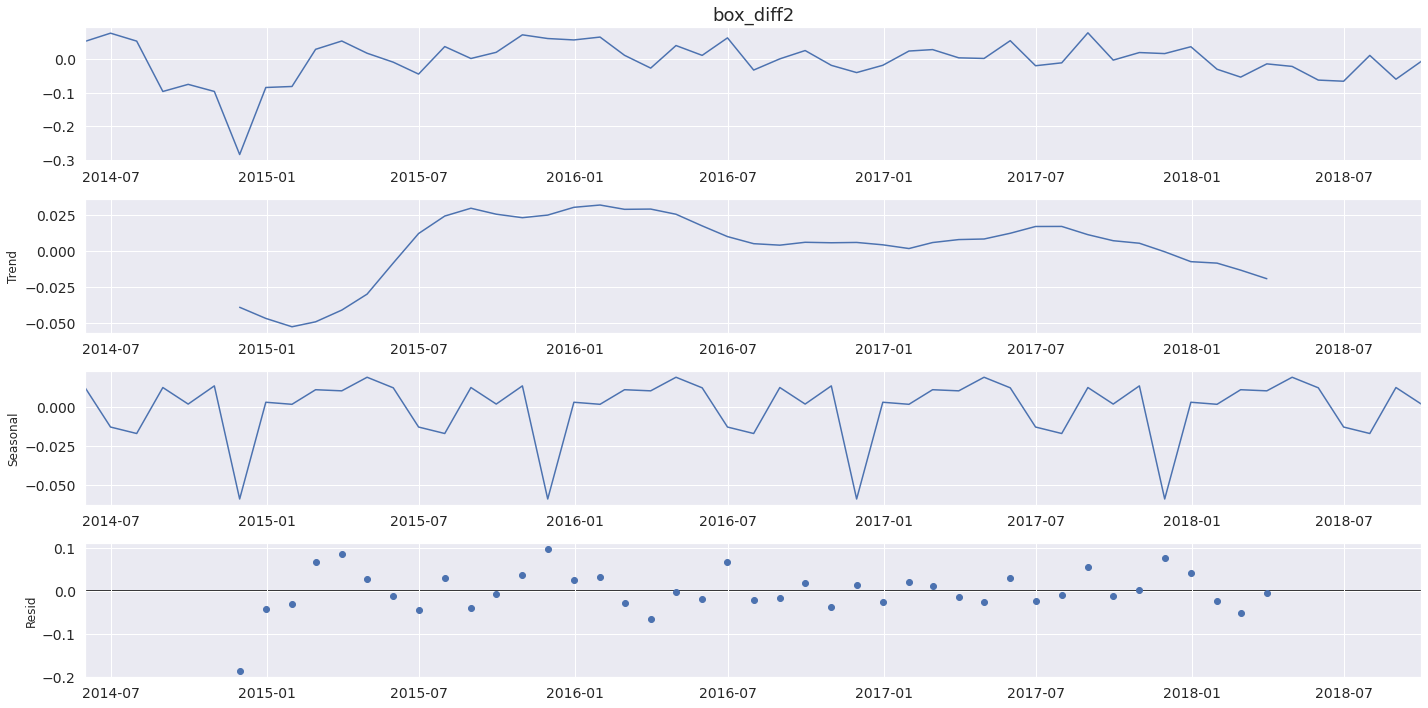

In [13]:
# Regular differentiation
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(btc_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])

The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05. 

### Autocorrelation  <a class="anchor" id="autocorrelation"></a>

Autocorrelation is the correlation of a time series with the same time series lagged. It summarizes the strength of a relationship with an observation in a time series with observations at prior time steps.

We create autocorrelation factor (ACF) and partial autocorrelation factor (PACF) plots to identify patterns in the above data which is stationary on both mean and variance. The idea is to identify presence of AR and MA components in the residuals. 

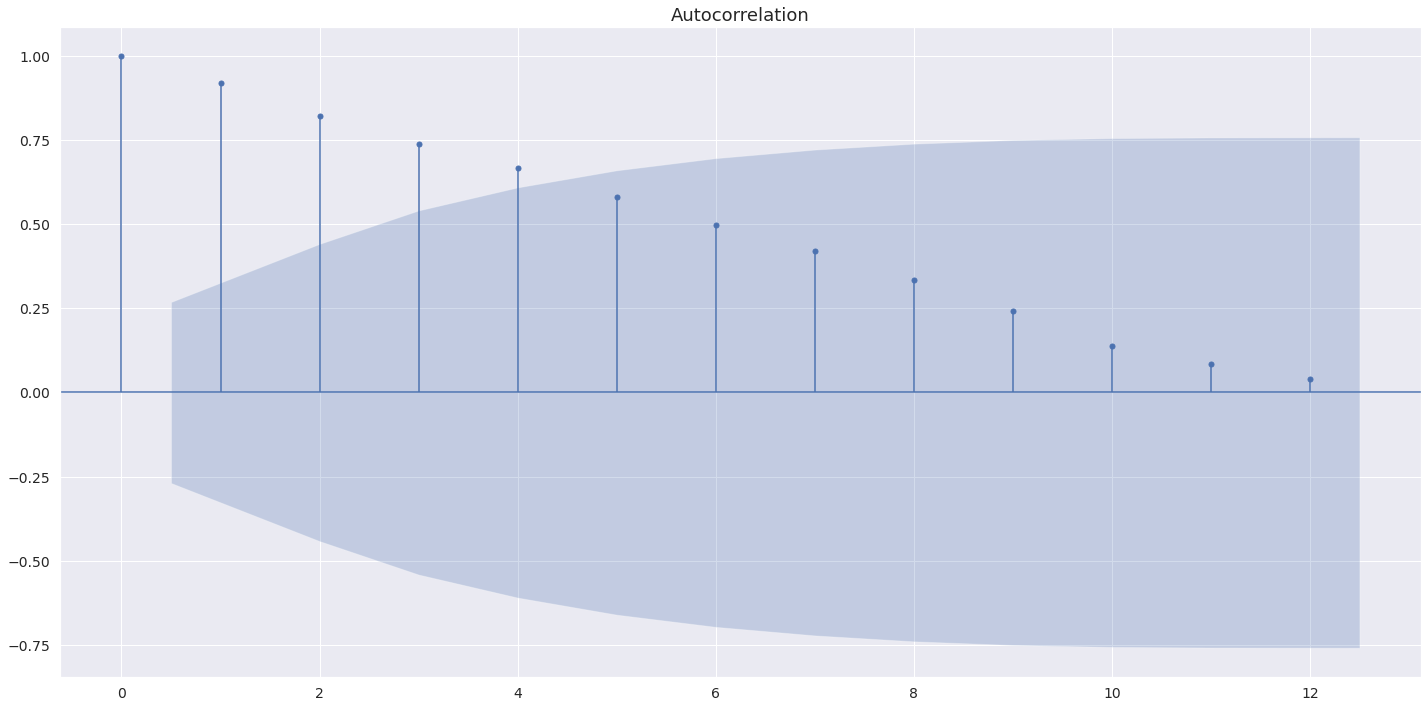

In [14]:
#autocorrelation_plot(btc_month.close)
plot_acf(btc_month.Close[13:].values.squeeze(), lags=12)
plt.tight_layout()

There is a positive correlation with the first 10 lags that is perhaps significant for the first 2-3 lags.

A good starting point for the AR parameter of the model may be 3.

Lets try out autocorrelation on the differences...

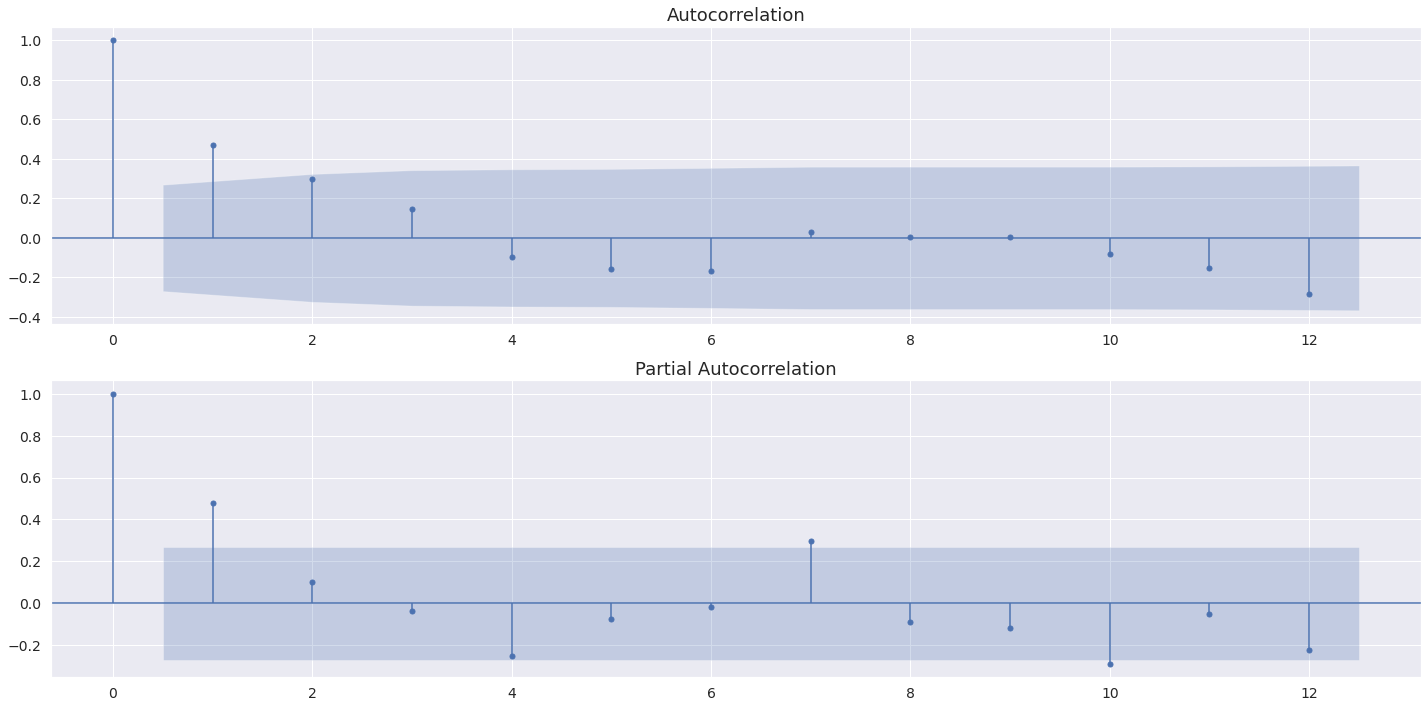

In [15]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
#sm.graphics.tsa.plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()

There are not many spikes in the plots outside the insignificant zone (shaded) so there may not be enough information available in the residuals to be extracted by AR and MA models. 

There may be a seasonal component available in the residuals at the lags of quarters (3 months) represented by spikes at these intervals. But probably not significant.

# Monthly Forecasting <a class="anchor" id="monthly_forecasting"></a>

## ARIMA Model  <a class="anchor" id="arima_model"></a>
AutoRegressive Integrated Moving Average

ARIMA models are denoted with the notation ARIMA(p, d, q). These parameters account for seasonality, trend, and noise in datasets:

    p - the number of lag observations to include in the model, or lag order. (AR)
    d - the number of times that the raw observations are differenced, or the degree of differencing. (I)
    q - the size of the moving average window, also called the order of moving average.(MA)

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.
A value of 0 for a parameter indicates to not use that element of the model. 

#### Parameter Selection

We will iteratively explore different combinations of parameters. For each combination we fit a new ARIMA model with SARIMAX() and assess its overall quality.

We will use the AIC (Akaike Information Criterion) value, returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [16]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

Note that some parameter combinations may lead to numerical misspecifications and we explicitly disabled warning messages in order to avoid an overload of warning messages. These misspecifications can also lead to errors and throw an exception, so we catch these exceptions and just print out the parameter combinations that cause these issues.

In [17]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
3     (1, 0) -214.284565
1     (0, 1) -213.745735
4     (1, 1) -212.318372
6     (2, 0) -212.312089
2     (0, 2) -212.053688


Note the AICs are negative but this is not a problem.

Usually, AIC is positive; however, it can be shifted by any additive constant, and some shifts can result in negative values of AIC. [...] It is not the absolute size of the AIC value, it is the relative values over the set of models considered, and particularly the differences between AIC values, that are important.

Ref: Model Selection and Multi-model Inference: A Practical Information-theoretic Approach (Burnham and Anderson, 2004)

In [18]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   66
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 109.142
Date:                Thu, 16 Mar 2023   AIC                           -214.285
Time:                        22:11:07   BIC                           -209.936
Sample:                    04-30-2013   HQIC                          -212.569
                         - 09-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3735      0.148      2.519      0.012       0.083       0.664
sigma2         0.0020      0.000     12.049      0.000       0.002       0.002
Ljung-Box (L1) (Q):                   0.02   Jarque-

### Analysis of Results  <a class="anchor" id="analysis_arima"></a>

The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.


When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

In [19]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


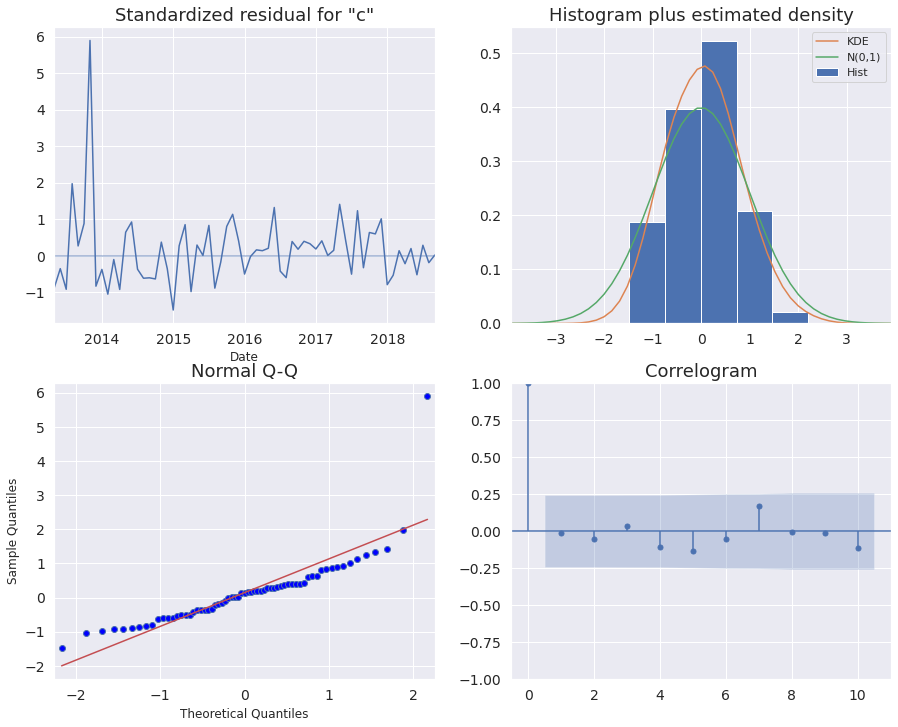

In [20]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

    In the histogram (top right), the KDE line should follow the N(0,1) line (normal distribution with mean 0, standard deviation 1) closely. This is an indication whether the residuals are normally distributed or not.

    In the Q-Q-plot the ordered distribution of residuals (blue dots) should follow the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is an indication whether the residuals are normally distributed.

    The standardized residual plot doesn't display any obvious seasonality. 
    This is confirmed by the autocorrelation plot, which shows that the time series residuals have low correlation with lagged versions of itself.

Conclusion: We may consider trying to standardise the distribution further. But lets go ahead and do a prediction anyway...

## Prediction <a class="anchor" id="prediction_arima"></a>

In [21]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Text(0, 0.5, 'USD')

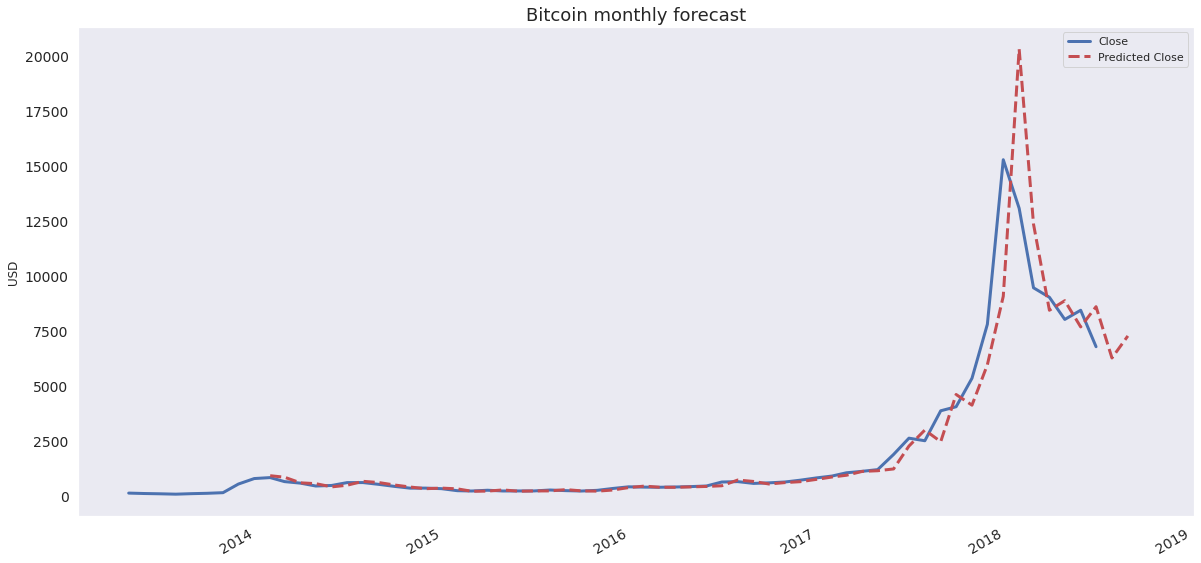

In [22]:
# Prediction
btc_month_pred = btc_month[['Close']]
date_list = [datetime(2018, 6, 30), datetime(2018, 7, 31), datetime(2018, 8, 31)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])

#btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2014, 1, 31), end=datetime(2018, 8, 31)), lmbda)

btc_month_pred.Close.plot(linewidth=3)
btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close', linewidth=3)
plt.legend()
plt.grid()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')

## SARIMAX  Model  <a class="anchor" id="sarimax_model"></a>
Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

I didn't expect the bitcoin data to display any seasonality but apparently it does display slight seasonality. So lets try to improve the model by using SARIMA.

When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

I have tried out this model with yearly and quarterly periods (toggle the commented out lines to see 12-month seasonal).

#### Parameter Selection

The same process of parameter selection for seasonal ARIMA. For each combination we fit a new seasonal ARIMA model with SARIMAX() and assess its overall quality.

In [23]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
#        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [24]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1) -188.672099
21  (1, 0, 1, 1) -188.380740
49  (2, 2, 0, 1) -188.263382
7   (0, 1, 0, 1) -187.994006
9   (0, 1, 1, 1) -187.343834
                                      SARIMAX Results                                      
Dep. Variable:                           close_box   No. Observations:                   66
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 4)   Log Likelihood                  97.336
Date:                             Thu, 16 Mar 2023   AIC                           -188.672
Time:                                     22:11:24   BIC                           -182.339
Sample:                                 04-30-2013   HQIC                          -186.190
                                      - 09-30-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

### Analysis of Results  <a class="anchor" id="analysis_sarimax"></a>

In [25]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.011294


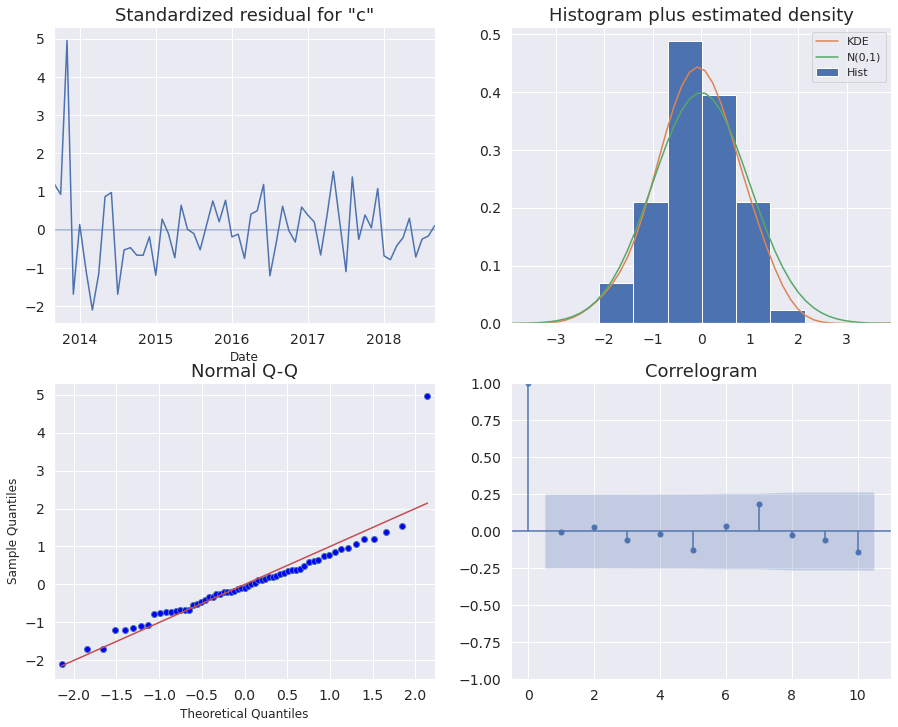

In [26]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Dickey–Fuller test:: p=0.011294


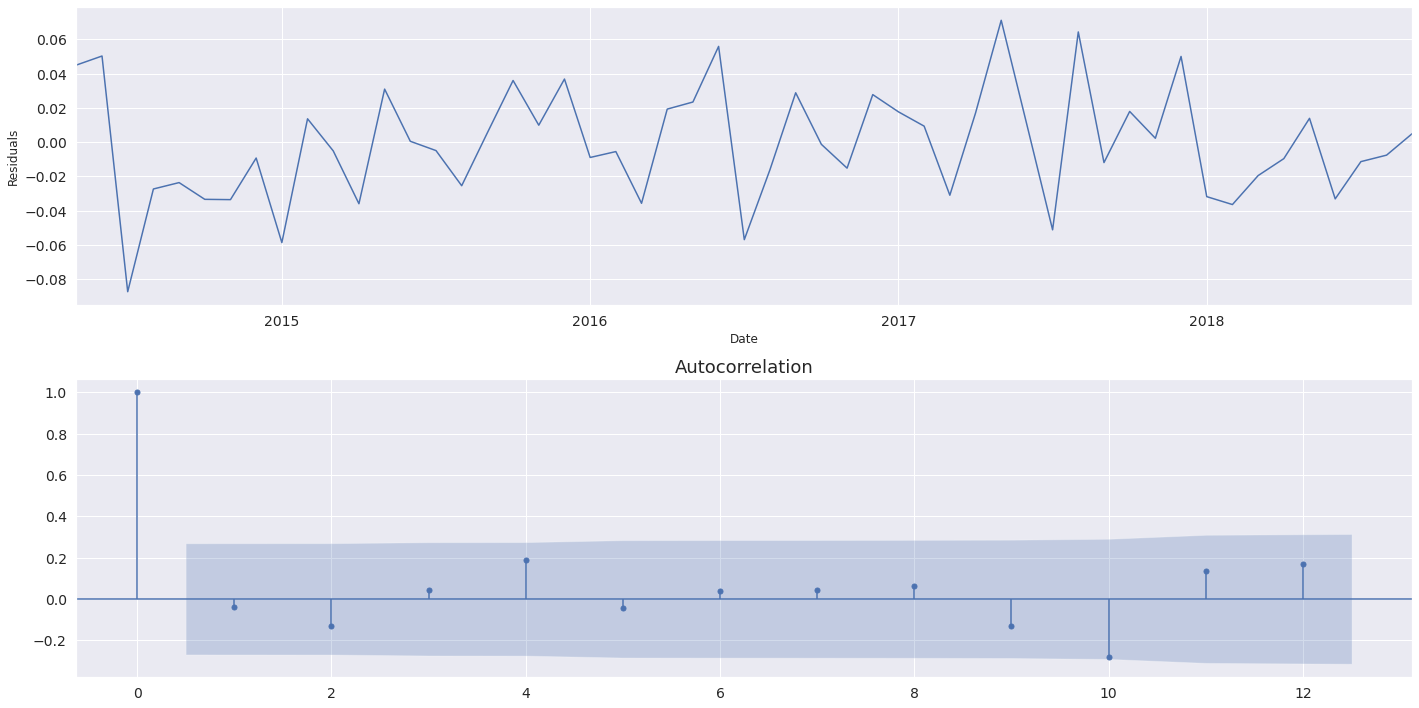

In [27]:
# STL-decomposition
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
#sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(best_model.resid[13:].values.squeeze(), lags=12, ax=ax)

print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

plt.tight_layout()

## Prediction  <a class="anchor" id="prediction_sarimax"></a>

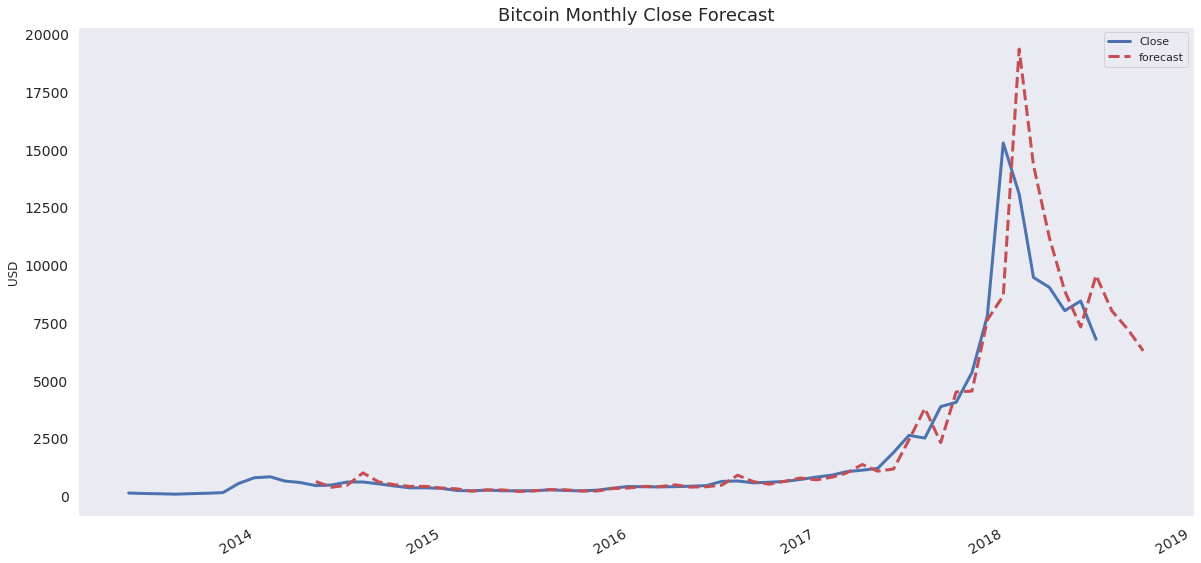

In [28]:
# Prediction
btc_month_sarima = btc_month[['Close']]
date_list = [datetime(2018, 6, 30), datetime(2018, 7, 31), datetime(2018, 8, 31)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_sarima = pd.concat([btc_month_sarima, future])

btc_month_sarima['forecast'] = invboxcox(best_model.predict(start=12, end=75), lmbda)

btc_month_sarima.Close.plot(linewidth=3)
btc_month_sarima.forecast.plot(color='r', ls='--', label='forecast', linewidth=3)
plt.legend()
plt.title('Bitcoin Monthly Close Forecast')
plt.ylabel('USD')
plt.grid()
plt.savefig('bitcoin_monthly_forecast.png')

## Validation <a class="anchor" id="validation"></a>

A simple indicator of how accurate out forecast is is the root mean square error (RMSE). So lets get a baseline and then calcualte the RMSE for the one-step ahead predictions starting from 2015, through to the end of 2017.

### Baseline <a class="anchor" id="baseline"></a>

The naive forecast, where the observation from the previous time step is used as the prediction for the observation at the next time step, can be taken as a simple baseline.

In [29]:
btc_month_predict = btc_month['2015-01-01':'2017-01-01']

# Get a naive forecast
close_history = [x for x in btc_month_predict['Close']]
predictions = list()
for i in range(len(btc_month_predict)):
    # predict
    predictions.append(close_history[-1])
    # update observation
    close_history.append(btc_month_predict.iloc[i]['Close'])
    
# Calculate RMSE
rmse = sqrt(mean_squared_error(btc_month_predict['Close'], predictions))
print('RMSE: %.2f' % rmse)

RMSE: 131.54


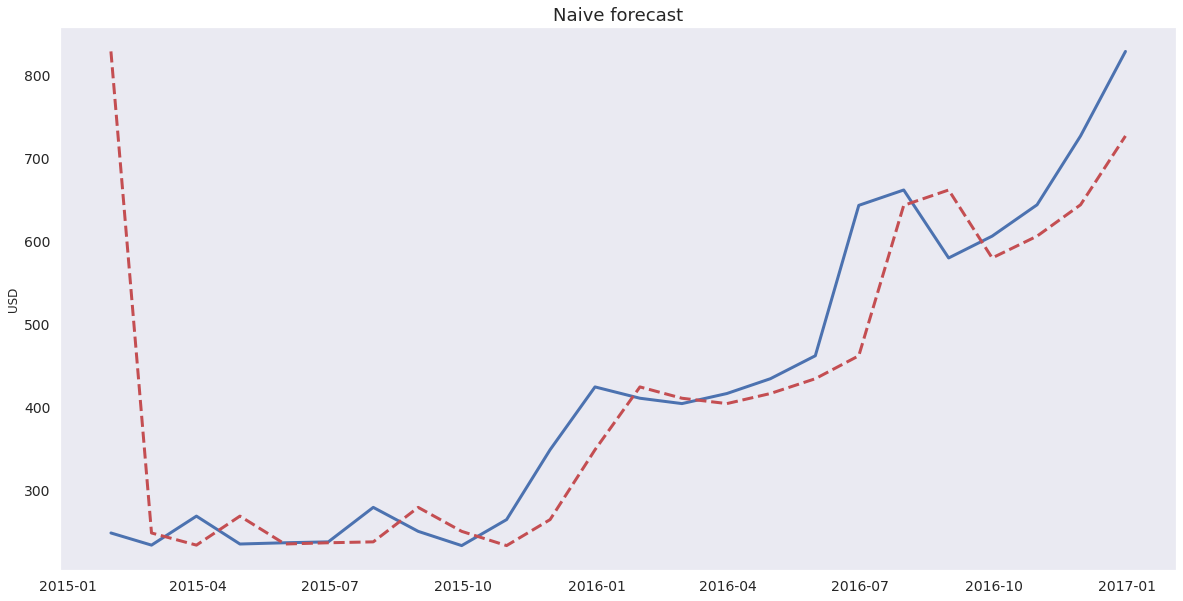

In [30]:
# Plot predictions vs actual
btc_month_predict['naive_forecast'] = predictions
plt.plot(btc_month_predict['Close'],  linewidth=3)
plt.plot(btc_month_predict['naive_forecast'], color='r', ls='--', label='forecast', linewidth=3)
plt.title('Naive forecast')
plt.ylabel('USD')
plt.grid()

### SARIMA <a class="anchor" id="validation_sarimax"></a>

In [31]:
y_forecasted = btc_month_sarima.forecast
y_truth = btc_month_sarima['2015-01-01':'2017-01-01'].Close

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 76.78


SARIMA does better than the naive forecast when measuring the MSE on a month-by-month prediction basis, ie: Using the actual close price of the last month in order to predict the close price of the next month.

A better representation of longer-term predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

In the code chunk below, we specify to start computing the dynamic forecasts and confidence intervals from mid 2017 onwards.

Text(0, 0.5, 'USD')

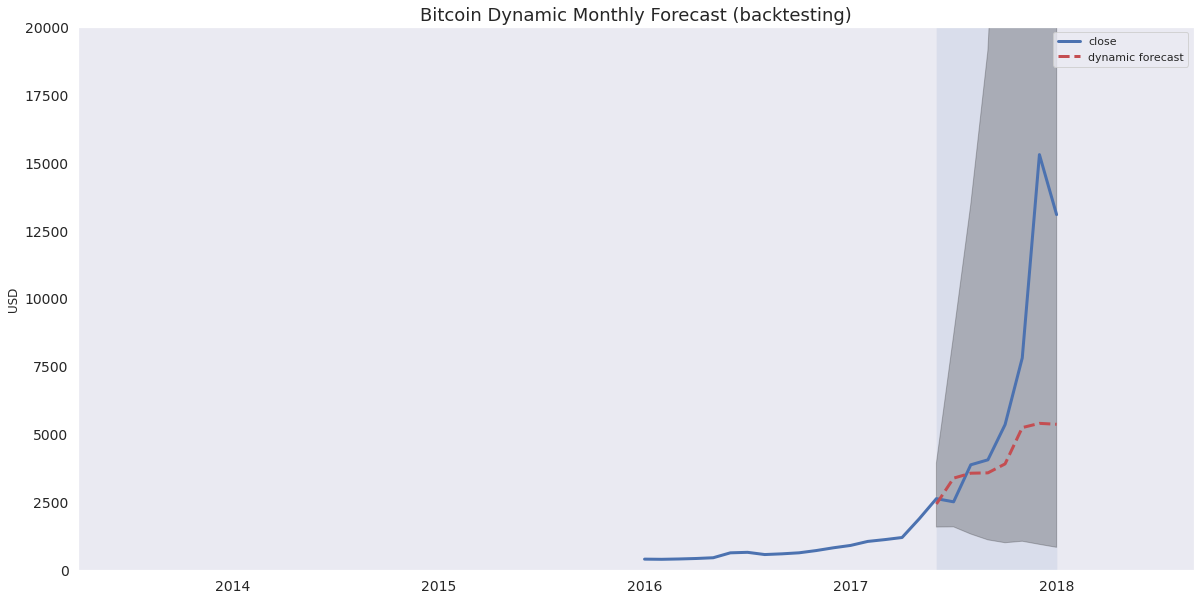

In [32]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2017-06-30')
t2 = pd.to_datetime('2018-01-31')
btc_month_dynamic = best_model.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
btc_month_sarima['dynamic_forecast'] = invboxcox(btc_month_dynamic.predicted_mean, lmbda)

# Taking 80% confidence interval because the 95% blows out too high to visualise
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha=0.2)
pred_dynamic_ci['lower close_box'] = invboxcox(pred_dynamic_ci['lower close_box'], lmbda)
pred_dynamic_ci['upper close_box'] = invboxcox(pred_dynamic_ci['upper close_box'], lmbda)

# Plot
plt.ylim((0,20000))

btc_month_sarima.Close['2016':'2018-01'].plot(label='close', linewidth=3)
btc_month_sarima.dynamic_forecast.plot(color='r', ls='--', label='dynamic forecast', linewidth=3)

plt.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha=.1, zorder=-1)

plt.legend()
plt.title('Bitcoin Dynamic Monthly Forecast (backtesting)')
plt.grid()
plt.ylabel('USD')

This is pretty bad but not surprising given how the prices started going insane around late 2017. Lets see how well the model does in a different time period when things were a little more normal.

Text(0, 0.5, 'USD')

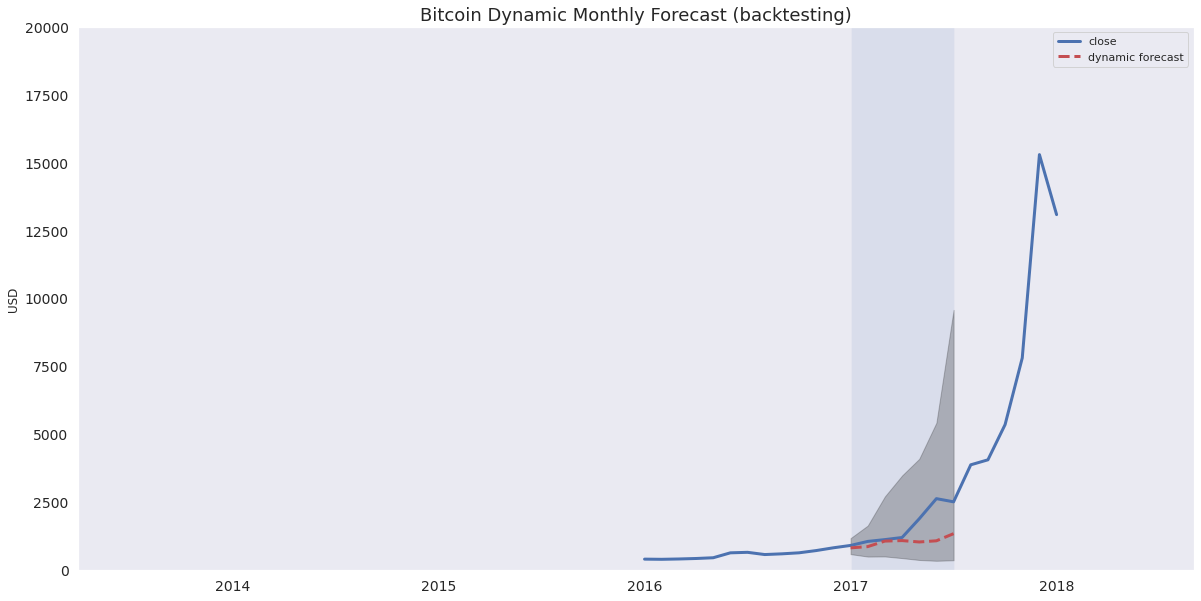

In [33]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2017-01-31')
t2 = pd.to_datetime('2017-07-31')
btc_month_dynamic = best_model.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
btc_month_sarima['dynamic_forecast'] = invboxcox(btc_month_dynamic.predicted_mean, lmbda)

# Taking 80% confidence interval because the 95% blows out too high to visualise
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha=0.2)
pred_dynamic_ci['lower close_box'] = invboxcox(pred_dynamic_ci['lower close_box'], lmbda)
pred_dynamic_ci['upper close_box'] = invboxcox(pred_dynamic_ci['upper close_box'], lmbda)

# Plot
plt.ylim((0,20000))

btc_month_sarima.Close['2016':'2018-01'].plot(label='close', linewidth=3)
btc_month_sarima.dynamic_forecast.plot(color='r', ls='--', label='dynamic forecast', linewidth=3)

plt.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha=.1, zorder=-1)

plt.legend()
plt.title('Bitcoin Dynamic Monthly Forecast (backtesting)')
plt.grid()
plt.ylabel('USD')

The results indicate that the model is still a little rough and not something we should use as trading advice, but that was not unexpected due to the extremely volatile nature of cryptocurrencies, especially in the last 6 months.

It is probably also not such a good idea to try and predict 6 months into the future as we can see how insane even the 80% confidence interval becomes out this far. Maybe sticking to 1 month advance predictitons is more sensible. Or maybe even predicting on a daily basis.

There are a number of things we could do to potentially improve the model. 
    - Use a different technique to standardise the distribution
    - Use different differentiation techniques
    - Discard the time period before cryptocurrencies started taking off
    - Try modelling per day instead of month, with a smaller forecast window
    - Use other models or machine learning instead of ARIMA


This is a work in progress. Please leave a comment and let me know if you think of any other ways this can be improved.